# Guide to load dataset for inference

This tutorial will show how to load data in LeRobot Format by using our enhanced `LeRobotDataset`, `MultiLeRobotDataset`, `MultimodaDataset`.

```bash
eo/data/
├── dataset.py
├── lerobot_dataset.py
├── multim_dataset.py
├── schema.py
└── transforms.py
```

## 1. Load LeRobot Dataset

This `LeRobotDataset` module provides custom LeRobot dataset implementations that extend the base classes from the `lerobot` library.
- Subtask training modes.
- Selection of specific video, state, and action keys.
- Dataset weighting for sampling.
- Delta action calculation.
- State and action normalization.

Here, we use a demo dataset `demos25` to show how to load data. Please download the dataset from the hub with the following command:

In [ ]:
# download dataset from hub
!huggingface-cli download --resume-download --local-dir-use-symlinks False --repo-type dataset \
    IPEC-COMMUNITY/demos25 --local-dir ../demo_data/test_demos25

- load meta data

In [2]:
from lerobot.datasets.lerobot_dataset import LeRobotDatasetMetadata

from eo.data.lerobot_dataset import LeRobotDataset

meta = LeRobotDatasetMetadata(
    repo_id="demos25",
    root="../demo_data/demos25",
)
meta

LeRobotDatasetMetadata({
    Repository ID: 'demos25',
    Total episodes: '25',
    Total frames: '44492',
    Features: '['observation.images.head', 'observation.images.hand_left', 'observation.images.hand_right', 'observation.states.effector.position', 'observation.states.end.orientation', 'observation.states.end.position', 'observation.states.head.position', 'observation.states.joint.current_value', 'observation.states.joint.position', 'observation.states.robot.orientation', 'observation.states.robot.position', 'observation.states.waist.position', 'actions.effector.position', 'actions.end.orientation', 'actions.end.position', 'actions.head.position', 'actions.joint.position', 'actions.robot.velocity', 'actions.waist.position', 'timestamp', 'frame_index', 'episode_index', 'index', 'task_index']',
})',

- load data

In [3]:
select_action_keys = [k for k in meta.features if k.startswith("action")]

dataset = LeRobotDataset(
    repo_id="demos25",
    root="../demo_data/demos25",
    delta_timestamps={
        k: [i / meta.fps for i in range(0, 50)]
        for k in select_action_keys
    }
)
dataset[0].keys()

dict_keys(['observation.images.head', 'observation.images.hand_left', 'observation.images.hand_right', 'observation.states.effector.position', 'observation.states.end.orientation', 'observation.states.end.position', 'observation.states.head.position', 'observation.states.joint.current_value', 'observation.states.joint.position', 'observation.states.robot.orientation', 'observation.states.robot.position', 'observation.states.waist.position', 'actions.effector.position', 'actions.end.orientation', 'actions.end.position', 'actions.head.position', 'actions.joint.position', 'actions.robot.velocity', 'actions.waist.position', 'task', 'actions.effector.position_is_pad', 'actions.end.orientation_is_pad', 'actions.end.position_is_pad', 'actions.head.position_is_pad', 'actions.joint.position_is_pad', 'actions.robot.velocity_is_pad', 'actions.waist.position_is_pad'])

### Specific Robot Keys
We can also select specific robot keys to load. For example, we can load the head, hand_left, and hand_right video streams, and the joint and effector position states and actions.

In [10]:
from lerobot.datasets.lerobot_dataset import LeRobotDatasetMetadata

from eo.data.lerobot_dataset import LeRobotDataset

dataset = LeRobotDataset(
    repo_id="demos25",
    root="../demo_data/demos25",
    select_video_keys=["observation.images.head", 'observation.images.hand_left', 'observation.images.hand_right'],
    select_state_keys=["observation.states.joint.position", "observation.states.effector.position"],
    select_action_keys=["actions.joint.position", "actions.effector.position"],
    delta_timestamps={k: [i / meta.fps for i in range(0, 1500)] for k in ["actions.joint.position", "actions.effector.position"]}
)
item = dataset[0]
item.keys()

dict_keys(['observation.images.head', 'observation.images.hand_left', 'observation.images.hand_right', 'observation.states.joint.position', 'observation.states.effector.position', 'actions.joint.position', 'actions.effector.position', 'task', 'actions.joint.position_is_pad', 'actions.effector.position_is_pad'])

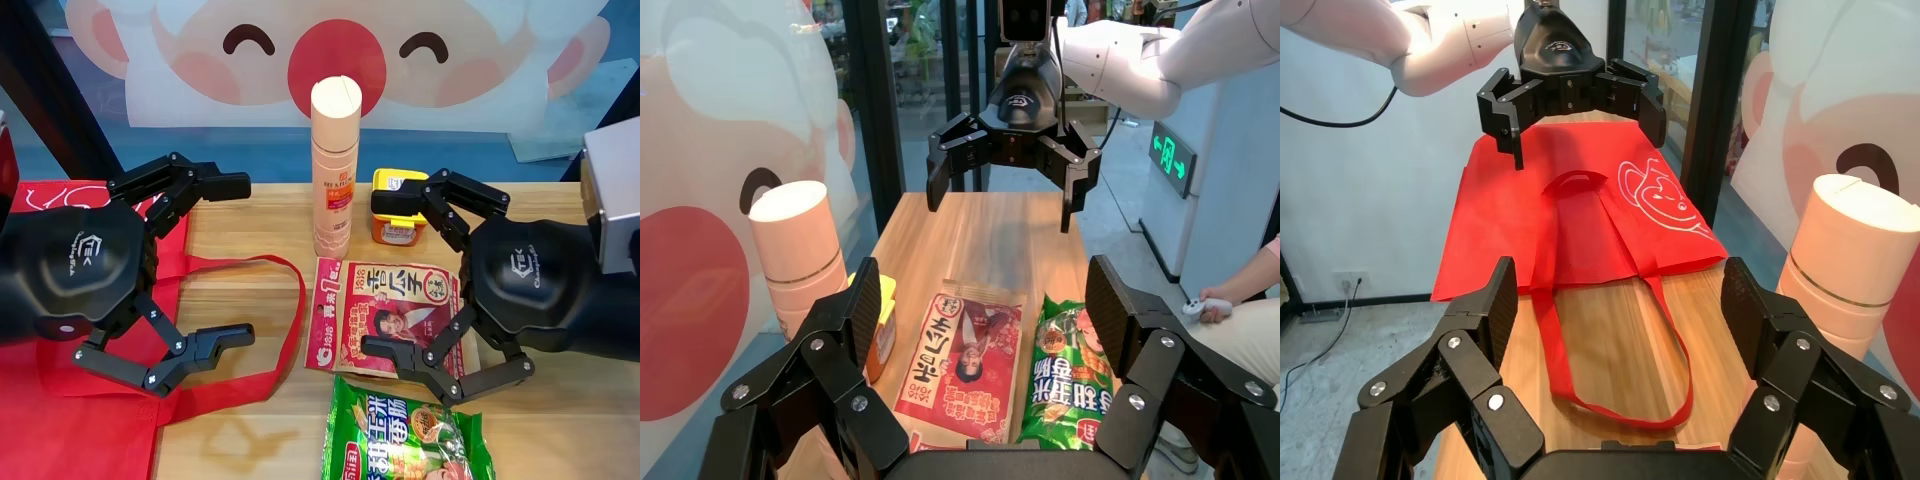

In [ ]:
from PIL import Image
import numpy as np
image = np.concatenate([dataset[0][k].permute(1, 2, 0).numpy() for \
    k in dataset.select_video_keys], axis=1) * 255
Image.fromarray(image.astype(np.uint8))

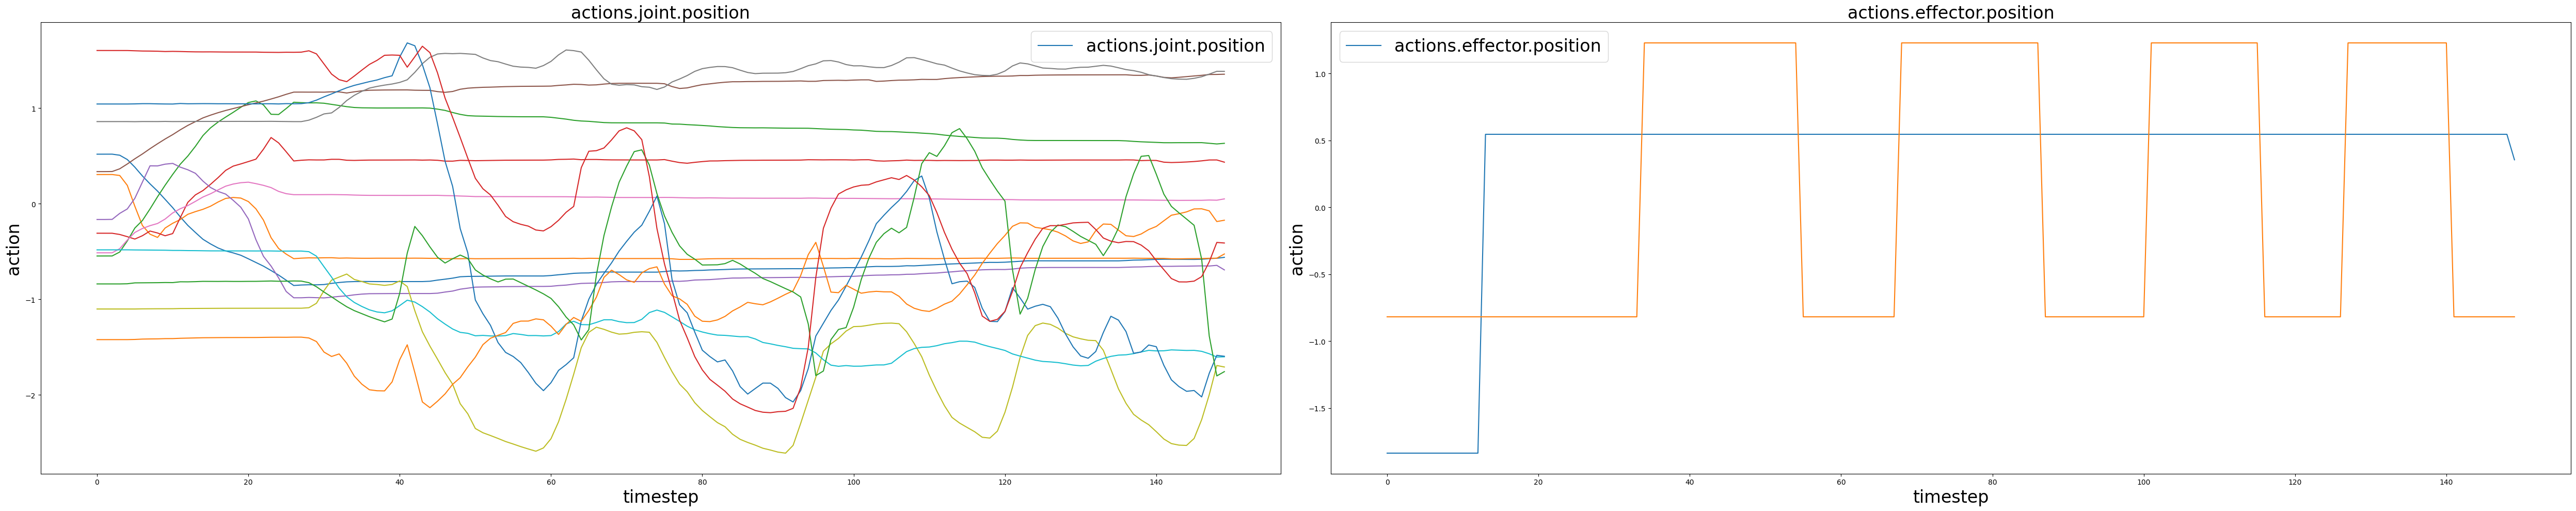

In [22]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, len(dataset.select_action_keys), figsize=(50, 10))

item = dataset[0]
for k, ax in zip(dataset.select_action_keys, axs):
    actions = item[k][::10].reshape(150, -1)
    for i in range(actions.shape[1]):
        ax.plot(actions[:, i])
    ax.legend([k], fontsize=24)
    ax.set_xlabel("timestep", fontsize=24)
    ax.set_ylabel("action", fontsize=24)
    ax.set_title(k, fontsize=24)
plt.tight_layout()

## 2. Load MultiLeRobotDataset Dataset
We use [MultiLeRobotDataset ../eo/data/lerobot_dataset.py#329](../eo/data/lerobot_dataset.py#329) to load multi-robot dataset.
`MultiLeRobotDataset` supports parallel loading to quickly load data, which is very useful in large-scale training, e.g. training with 200+ robots datasets.

Use [LerobotConfig ../eo/data/schema.py#12](../eo/data/schema.py#12) to specify the dataset config for each robot, where:

```python
@dataclass
class LerobotConfig:
    repo_id: str # the repo id of the robot dataset
    root: str # the root path of the robot dataset
    episodes: list[int] | None = None # Optional, `the episodes to load
    delta_action: bool = False # Optional, whether to load delta actions
    state_mode: str = "MEAN_STD" # Optional, the state normalization mode

    train_subtask: str | bool | None = False  # Optional[true, false, mix:0.5, cumulate] # the tasks prompts to hybridize with the overall instructions
    select_video_keys: list[str] = None # Optional, the video keys to load
    select_action_keys: list[str] = None # Optional, the action keys to load
    select_state_keys: list[str] = None # Optional, the state keys to load
    effector_indices: list[int] = None # Optional, the effector indices to load
    weight: float | None = None # Optional, the weight of the dataset for sampling
```

In the following example, we load two robot datasets, `demos25` and `libero_spatial_no_noops_1.0.0_lerobot`. All the features keys will be loaded from the metadata, which is different from the `LeRobotDataset` that only computes the intersection of features.

In [28]:
from lerobot.datasets.lerobot_dataset import LeRobotDatasetMetadata

from eo.data.lerobot_dataset import MultiLeRobotDataset
from eo.data.schema import LerobotConfig

# we use yaml data configs in large scale training
multi_dataset = MultiLeRobotDataset(
    data_configs=[
        LerobotConfig(
            repo_id="demos25",
            root="../demo_data",
            episodes=[0],
        ),
        LerobotConfig(
            repo_id="libero_spatial_no_noops_1.0.0_lerobot",
            root="../demo_data",
            episodes=[0],
        )
    ],
    chunk_size=16 # automatically construct delta_timestamps from the `metadata` and `chunk_size`
)

print(multi_dataset._datasets)

* load 2 lerobot datasets with 8 processes ...


The dataset you requested (libero_spatial_no_noops_1.0.0_lerobot) is in 2.0 format.
While current version of LeRobot is backward-compatible with it, the version of your dataset still uses global
stats instead of per-episode stats. Update your dataset stats to the new format using this command:
```
python -m lerobot.datasets.v21.convert_dataset_v20_to_v21 --repo-id=libero_spatial_no_noops_1.0.0_lerobot
```

If you encounter a problem, contact LeRobot maintainers on [Discord](https://discord.com/invite/s3KuuzsPFb)
or open an [issue on GitHub](https://github.com/huggingface/lerobot/issues/new/choose).

Loading lerobot datasets:   0%|          | 0/2 [00:00<?, ?it/s]WARNING:root:
The dataset you requested (libero_spatial_no_noops_1.0.0_lerobot) is in 2.0 format.
While current version of LeRobot is backward-compatible with it, the version of your dataset still uses global
stats instead of per-episode stats. Update your dataset stats to the new format using this command:
```
python -m lerobot

[warn] libero_spatial_no_noops_1.0.0_lerobot failed to calculate episode subtask cumulate: 'action_config'
* set train_subtask None for libero_spatial_no_noops_1.0.0_lerobot
[warn] demos25 failed to calculate episode subtask cumulate: 'action_config'
* set train_subtask None for demos25


Loading lerobot datasets: 100%|██████████| 2/2 [00:24<00:00, 12.10s/it]

successfully load dataset 2/2:
['demos25', 'libero_spatial_no_noops_1.0.0_lerobot'] 
[LeRobotDataset({
    Repository ID: 'demos25',
    Number of selected episodes: '1',
    Number of selected samples: '1719',
    Features: '['observation.images.head', 'observation.images.hand_left', 'observation.images.hand_right', 'observation.states.effector.position', 'observation.states.end.orientation', 'observation.states.end.position', 'observation.states.head.position', 'observation.states.joint.current_value', 'observation.states.joint.position', 'observation.states.robot.orientation', 'observation.states.robot.position', 'observation.states.waist.position', 'actions.effector.position', 'actions.end.orientation', 'actions.end.position', 'actions.head.position', 'actions.joint.position', 'actions.robot.velocity', 'actions.waist.position', 'timestamp', 'frame_index', 'episode_index', 'index', 'task_index']',
})',
, LeRobotDataset({
    Repository ID: 'libero_spatial_no_noops_1.0.0_lerobot',
  

More generally, we recommend using a YAML configuration file to specify the dataset configuration, for example:
```yaml
# @robot control config
lerobot_datasets:
  - repo_id: demo25
    root: ./demo_data
  
  - repo_id: libero_spatial_no_noops_1.0.0_lerobot
    root: HF_LEROBOT_HOME
```
More details can be found in [experiments/2_libero/data-libero.yaml](../experiments/2_libero/data-libero.yaml).

## 3. Load MultiModal Datasets

To train with multimodal data, e.g., image, video, text, points and bounding boxes, we use `MultimodaDataset` to load multimodal data. [MMDatasetConfig](../eo/data/schema.py#23) helps to specify the dataset config for each multimodal dataset.
```python
@dataclass
class MMDatasetConfig:
    json_path: str # the path to the jsonl file
    vision_base_path: str # the base path of the vision data
    sampling_strategy: str = "random:10%" # the sampling strategy
```
In the following example, we load a multimodal dataset from a jsonl file, and visualize the first sample.

In [7]:
import pprint
from eo.data.multim_dataset import MultimodaDataset
from eo.data.schema import MMDatasetConfig
import json

multim_dataset = MultimodaDataset(
    data_configs = [
        MMDatasetConfig(
            json_path="../demo_data/refcoco/refcoco.jsonl",
            vision_base_path="../demo_data/refcoco"
        ),
    ]
)

print(json.dumps(multim_dataset[0], indent=2, ensure_ascii=False))

Loaded 9 samples from ../demo_data/refcoco/refcoco.jsonl
{
  "question_id": "710706",
  "image": "images/COCO_train2014_000000580957_2.jpg",
  "conversations": [
    {
      "role": "user",
      "content": "<|vision_start|><|image_pad|><|vision_end|>Locate bowl of carrots and annotate its bounding box, providing the output in json format."
    },
    {
      "role": "assistant",
      "content": "```json\n[\n    {\"bbox_2d\": [86, 82, 345, 249], \"label\": \"bowl of carrots\"}\n]\n```"
    }
  ],
  "seq_length": 198,
  "vision_base_idx": 0
}


Plotting Util

In [15]:
import json
import random
import io
import ast
from PIL import Image, ImageDraw
from PIL import ImageColor
import xml.etree.ElementTree as ET

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

def decode_xml_points(text):
    try:
        root = ET.fromstring(text)
        num_points = (len(root.attrib) - 1) // 2
        points = []
        for i in range(num_points):
            x = root.attrib.get(f'x{i+1}')
            y = root.attrib.get(f'y{i+1}')
            points.append([x, y])
        alt = root.attrib.get('alt')
        phrase = root.text.strip() if root.text else None
        return {
            "points": points,
            "alt": alt,
            "phrase": phrase
        }
    except Exception as e:
        print(e)
        return None

def plot_bounding_boxes(im, bounding_boxes, input_width, input_height):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    'pink',
    'purple',
    'brown',
    'gray',
    'beige',
    'turquoise',
    'cyan',
    'magenta',
    'lime',
    'navy',
    'maroon',
    'teal',
    'olive',
    'coral',
    'lavender',
    'violet',
    'gold',
    'silver',
    ] + additional_colors

    # Parsing out the markdown fencing
    bounding_boxes = parse_json(bounding_boxes)

    try:
      json_output = ast.literal_eval(bounding_boxes)
    except Exception as e:
      end_idx = bounding_boxes.rfind('"}') + len('"}')
      truncated_text = bounding_boxes[:end_idx] + "]"
      json_output = ast.literal_eval(truncated_text)

    # Iterate over the bounding boxes
    for i, bounding_box in enumerate(json_output):
      # Select a color from the list
      color = colors[i % len(colors)]

      # Convert normalized coordinates to absolute coordinates
      abs_y1 = int(bounding_box["bbox_2d"][1]/input_height * height)
      abs_x1 = int(bounding_box["bbox_2d"][0]/input_width * width)
      abs_y2 = int(bounding_box["bbox_2d"][3]/input_height * height)
      abs_x2 = int(bounding_box["bbox_2d"][2]/input_width * width)

      if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1

      if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1

      # Draw the bounding box
      draw.rectangle(
          ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
      )

      # Draw the text
      if "label" in bounding_box:
        draw.text((abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill=color)

    # Display the image
    return img


def plot_points(im, text, input_width, input_height):
  img = im
  width, height = img.size
  draw = ImageDraw.Draw(img)
  colors = [
    'red', 'green', 'blue', 'yellow', 'orange', 'pink', 'purple', 'brown', 'gray',
    'beige', 'turquoise', 'cyan', 'magenta', 'lime', 'navy', 'maroon', 'teal',
    'olive', 'coral', 'lavender', 'violet', 'gold', 'silver',
  ] + additional_colors
  xml_text = text.replace('```xml', '')
  xml_text = xml_text.replace('```', '')
  data = decode_xml_points(xml_text)
  if data is None:
    img.show()
    return
  points = data['points']
  description = data['phrase']

  for i, point in enumerate(points):
    color = colors[i % len(colors)]
    abs_x1 = int(point[0])/input_width * width
    abs_y1 = int(point[1])/input_height * height
    radius = 2
    draw.ellipse([(abs_x1 - radius, abs_y1 - radius), (abs_x1 + radius, abs_y1 + radius)], fill=color)
    draw.text((abs_x1 + 8, abs_y1 + 6), description, fill=color)
  
  img.show()
  

# @title Parsing JSON output
def parse_json(json_output):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i+1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

{'question_id': '710706', 'image': 'images/COCO_train2014_000000580957_2.jpg', 'conversations': [{'from': 'human', 'value': '<image>Locate bowl of carrots and annotate its bounding box, providing the output in json format.'}, {'from': 'gpt', 'value': '```json\n[\n    {"bbox_2d": [86, 82, 345, 249], "label": "bowl of carrots"}\n]\n```'}], 'seq_length': 198, 'vision_base_idx': 0}
(364, 252)
{'question_id': '480908', 'image': 'images/COCO_train2014_000000580905_2.jpg', 'conversations': [{'from': 'human', 'value': '<image>Identify and mark the bounding box for little girl.'}, {'from': 'gpt', 'value': '```json\n[\n    {"bbox_2d": [67, 157, 167, 252], "label": "little girl"}\n]\n```'}], 'seq_length': 190, 'vision_base_idx': 0}
(364, 252)
{'question_id': '98434', 'image': 'images/COCO_train2014_000000168643_2.jpg', 'conversations': [{'from': 'human', 'value': '<image>In json format, please annotate the bounding box for 3 cushion couch.'}, {'from': 'gpt', 'value': '```json\n[\n    {"bbox_2d": 

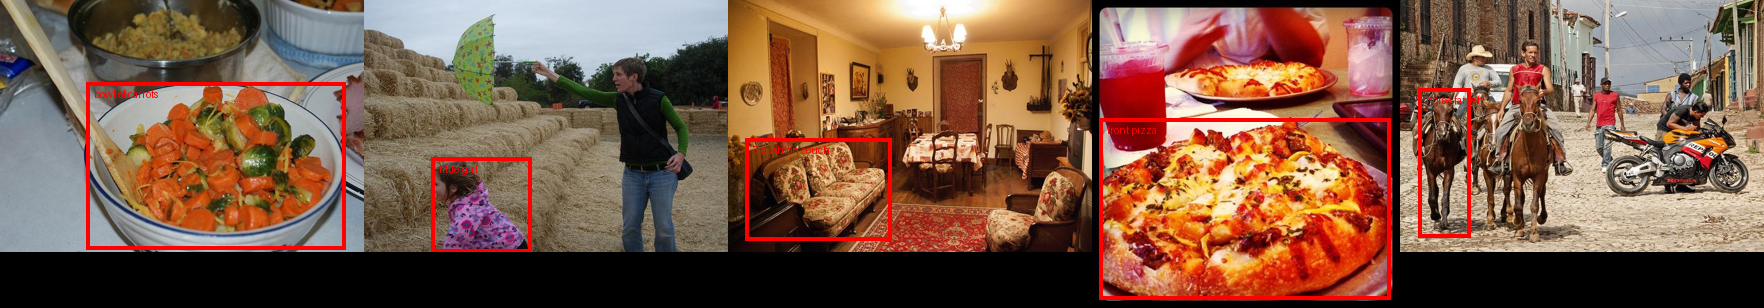

In [27]:
from qwen_vl_utils import smart_resize
images = []
for i in range(5):
    item = multim_dataset[i]
    bounding_boxes = item['conversations'][1]['content']
    image = Image.open(f"../demo_data/refcoco/{item['image']}")
    w, h = image.size
    h_bar, w_bar = smart_resize(
        h, w, min_pixels=64 * 28 * 28, max_pixels=128 * 28 * 28
    )
    image = image.resize((w_bar, h_bar))
    images.append(plot_bounding_boxes(image,bounding_boxes,w_bar,h_bar))


total_width = sum(img.width for img in images)
max_height = max(img.height for img in images)
combined_image = Image.new('RGB', (total_width, max_height))
x_offset = 0
for img in images:
    combined_image.paste(img, (x_offset, 0))
    x_offset += img.width
combined_image

### Load MultiModal Interleaved Datasets

NOTE: Now we update our dataset in parquat, https://huggingface.co/datasets/IPEC-COMMUNITY/EO-Data1.5M. NOTE: We have now updated our dataset to the [Parquet format](https://huggingface.co/datasets/IPEC-COMMUNITY/EO-Data1.5M). The meta_dataset has been deprecated — we no longer merge the LeRobot dataset with the multimodal dataset.

For Multimodal data, e.g., image, video, text, points and bounding boxes, we follow the [Qwen2.5-VL](https://colab.research.google.com/github/QwenLM/Qwen2.5-VL/blob/main/cookbooks/spatial_understanding.ipynb) and [Qwen2-VL-Finetune](https://github.com/2U1/Qwen2-VL-Finetune) recipes. In interleaved pretraining, we integrate the EO-Data1.5M dataset — a large-scale, high-quality embodied dataset designed to unify reasoning and control. Data are organized in a standardized format as shown below:

<p align="left"> <img src="../.assets/data_example.png" width="100%"> </p>

Here, the `lerobot` and `view` fields connect actions with multimodal conversations, enabling the model to capture the rich temporal dynamics and causal dependencies among vision, language, and action modalities — a core requirement for robust performance in open-world embodied interactions. For more details, please refer to [getting_started/1_load_dataset](getting_started/1_load_dataset.ipynb)

To combine robot control data and multimodal data, we support a [flexible YAML-based configuration](eo/data/schema.py), where each dataset can be assigned weights and sampling strategies. This makes it easy to balance embodied control trajectories with multimodal reasoning data for interleaved training. For example:

```yaml
# @multimodal data config
mm_datasets:
  # classical multimodal data
  - json_path: demo_data/refcoco/refcoco.jsonl # jsonl file
    vision_base_path: demo_data/refcoco # base path for vision data files referenced in the JSONL
    sampling_strategy: random:10% # sampling strategy

  # interleaved data jsonl, rely on `lerobot_datasets` to load robot control data
  - json_path: demo_data/interleaved_demo.jsonl

# @robot control config
lerobot_datasets:
  - repo_id: demo25
    root: ./demo_data
    # Optional fields:
    episodes: [1, 2, 3] # specific episodes to load (None = all)
    train_subtask: mix:0.9 # mix sub-task instructions and overall instructions with 90% sub-task
    delta_action: false # train with delta actions
    state_mode: "MEAN_STD" # state normalization mode
    select_video_keys: # which camera streams to load
      [
        observation.images.head,
        observation.images.hand_left,
        observation.images.hand_right,
      ]
    select_state_keys: # proprioceptive states
      [observation.states.joint.position, observation.states.effector.position]
    select_action_keys: # action targets
      [actions.joint.position, actions.effector.position]
    effector_indices: [14, 15] # indices of effector channels in the flattened action vector
    weight: 1.0 # dataset weight for sampling
```

In [2]:
from eo.data.lerobot_dataset import MultiLeRobotDataset
from eo.data.multim_dataset import MultimodaDataset
from eo.data.schema import MMDatasetConfig, LerobotConfig

lerobot_dataset = MultiLeRobotDataset(
    data_configs=[
        LerobotConfig(
            repo_id="demos25",
            root="../demo_data",
            select_video_keys=["observation.images.head", 'observation.images.hand_left', 'observation.images.hand_right'],
            select_state_keys=["observation.states.joint.position", "observation.states.effector.position"],
            select_action_keys=["actions.joint.position", "actions.effector.position"],
        )
    ],
    chunk_size=16 # automatically construct delta_timestamps from the `metadata` and `chunk_size`
)

/mnt/shared-storage-user/eorobotics-shared/miniconda3/envs/eo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* load 1 lerobot datasets with 8 processes ...


Loading lerobot datasets:   0%|          | 0/1 [00:00<?, ?it/s]

[warn] demos25 failed to calculate episode subtask cumulate: 'action_config'
* set train_subtask None for demos25


Loading lerobot datasets: 100%|██████████| 1/1 [00:25<00:00, 25.71s/it]

successfully load dataset 1/1:
['demos25'] 


In [3]:
interleaved_dataset = MultimodaDataset(
    data_configs = [
        MMDatasetConfig(
            json_path="../demo_data/demos25/interleaved_demo.jsonl"
        ),
    ],
    meta_dataset = lerobot_dataset
)

print(f"{len(interleaved_dataset)=}, {len(interleaved_dataset.data)=}, {len(interleaved_dataset.meta_dataset)=}")

Loaded 1132 samples from ../demo_data/demos25/interleaved_demo.jsonl
len(interleaved_dataset)=1132, len(interleaved_dataset.data)=1132, len(interleaved_dataset.meta_dataset)=44492


In [11]:
import pprint
import json

print(json.dumps(interleaved_dataset.data[0], indent=2, ensure_ascii=False))

print("multimodal data", interleaved_dataset.data[0].keys())
print("interleaved data", interleaved_dataset[0].keys())

{
  "lerobot": [
    "demos25 0 0",
    "demos25 299 0",
    "demos25 414 0",
    "demos25 619 0"
  ],
  "conversations": [
    {
      "from": "human",
      "value": "<image>Can retrieve the sunflower seeds from the table with the right arm be done now?"
    },
    {
      "from": "gpt",
      "value": "no"
    },
    {
      "from": "human",
      "value": "<image>What should be the next step to move toward packing in the supermarket?"
    },
    {
      "from": "gpt",
      "value": "grab the packaged ham sausage on the table with the right arm"
    },
    {
      "from": "human",
      "value": "<image>Can you outline the contents of the current scene?"
    },
    {
      "from": "gpt",
      "value": "The robotic arm holds a green snack bag above a red shopping bag. Various items, including a yellow box and a white tube, are arranged on the table nearby."
    },
    {
      "from": "human",
      "value": "<image>With these actions completed: 0-grasp the left arm with red canvas 